In [3]:
# Critical to get imports working
# https://stackoverflow.com/questions/39299838/how-do-i-import-module-in-jupyter-notebook-directory-into-notebooks-in-lower-dir

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import src.utilities.segmentation.brute.grayscale_segmentation as seg

import src.utilities.segmentation.xianauto.automatic_segmentation as xian

from src.constants.ultrasoundConstants import (
    FRAME_DEFAULT_ROW_CROP_FOR_SCAN_SELECTION,
    FRAME_DEFAULT_COL_CROP_FOR_SCAN_SELECTION
)

CONNECTIVITY = 4
MIN_RADIUS = 1
MAX_RADIUS = 20

In [6]:
def absolute_max(ndarray):
    return np.max(ndarray.flatten())

def absolute_min(ndarray):
    return np.min(ndarray.flatten())

def get_region(image, start, end):
    return image[start[0]:end[0], start[1]:end[1]]

In [7]:
def iterate_until_stop_growing_exponential_backoff(
    binary_image,
    routine,
    *args,
    **kwargs):
        
    max_iters = np.max(binary_image.shape) ** 2
    count = np.count_nonzero(binary_image)
    current_image = np.copy(binary_image)
    iters_in_round = 1
    
    while True:
        
        # Execute iterations in round
        for it in range(iters_in_round):
            current_image = routine(current_image, *args, **kwargs)
        
        new_count = np.count_nonzero(current_image)
        
        if new_count == count:
            return current_image
        elif iters_in_round >= max_iters:
            return current_image
        else:
            count = new_count
            iters_in_round *= 2
                    
    return current_image

In [8]:
def grow_region(binary_image, thresh, kernel, iters_per_round=1):
    growth_region = cv2.dilate(binary_image, kernel, iterations = iters_per_round)
    growth_region = cv2.bitwise_and(growth_region, thresh)
    growth_region = cv2.morphologyEx(growth_region, cv2.MORPH_OPEN, kernel)
    return growth_region

In [9]:
def disk_kernel(radius):
    kernel = np.zeros((2*radius+1, 2*radius+1))
    y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    kernel[mask] = 1
    return kernel.astype(np.uint8)

In [10]:
def mask_fit_kernel(mask, kernel):
    return np.count_nonzero(cv2.erode(mask, kernel, iterations=1)) == 0

In [11]:
def max_interior_radius(low, high, mask):
    while low <= high:        
        mid = (low + high) // 2
        if mask_fit_kernel(mask, disk_kernel(mid)):
            high = mid - 1            
        else:
            low = mid + 1
            
    return mid

In [31]:
def as_binary_mask(image):
    return (image > 0).astype(np.uint8)

In [38]:
"""
Find the largest kernel that 'fits' in the mask. 
Fit is defined as erosion not-completely erasing the mask region (i.e. at least one non-zero value post-erosion)
"""
def prune_mask_to_kernel_radius(mask, radius):
    pruned_mask = np.zeros(mask.shape, np.uint8)
    nlabels, labeled = cv2.connectedComponents(mask, CONNECTIVITY)
    for l in range(1, nlabels):
        component = (labeled == l).astype(np.uint8)
        if max_interior_radius(MIN_RADIUS, MAX_RADIUS, component) < radius:
            pruned_mask += component
            
    return pruned_mask


def find_leak_mask_to_kernel_radius(mask, radius):
    leak_mask = np.zeros(mask.shape, np.uint8)
    nlabels, labeled = cv2.connectedComponents(mask, CONNECTIVITY)
    for l in range(1, nlabels):
        component = (labeled == l).astype(np.uint8)
        if max_interior_radius(MIN_RADIUS, MAX_RADIUS, component) >= radius:
            leak_mask += component
            
    return leak_mask

## Prune to kernel mask check

2139
2034
115
115


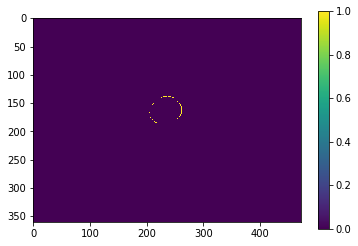

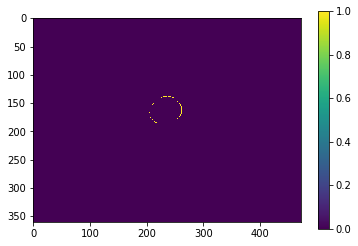

In [30]:
radius_19 = iterate_until_stop_growing_exponential_backoff(
    np.copy(seed_region_mask),
    grow_region,
    seed_range_thresholded_image,
    disk_kernel(19),
    iters_per_round = 3)
print(np.count_nonzero(radius_19))

radius_20 = iterate_until_stop_growing_exponential_backoff(
    np.copy(seed_region_mask),
    grow_region,
    seed_range_thresholded_image,
    disk_kernel(20),
    iters_per_round = 3)
print(np.count_nonzero(radius_20))

plt.figure()
plt.imshow(((radius_19 - radius_20) > 0).astype(np.uint8))
print(np.count_nonzero(radius_19 - radius_20))
plt.colorbar()
plt.figure()
plt.imshow(prune_mask_to_kernel_radius(radius_19 - radius_20, 19))
print(np.count_nonzero(prune_mask_to_kernel_radius(radius_19 - radius_20, 19)))
plt.colorbar()


### Load frame from file

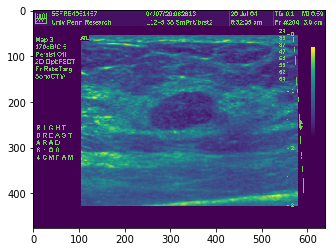

In [14]:
frame = cv2.imread("../../TestImages/frames/frame_0003.png", cv2.IMREAD_GRAYSCALE)
M, N = frame.shape

plt.imshow(frame)

### Select scan window from frame

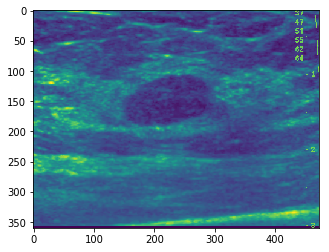

In [15]:
scan_window, scan_bounds = seg.select_scan_window_from_frame(
    frame, 
    0,
    255,
    select_bounds = (
        slice(FRAME_DEFAULT_ROW_CROP_FOR_SCAN_SELECTION, M), 
        slice(FRAME_DEFAULT_COL_CROP_FOR_SCAN_SELECTION, N)))

plt.imshow(scan_window)

### Determine seed point in scan window 

In [16]:
SEED_REGION_RADIUS = 2

_, seed_pt = xian.get_ROI_debug(scan_window)
seed_pt = np.flip(seed_pt.astype(int), axis=0)

## Rectangle bounds

start_pt = seed_pt - SEED_REGION_RADIUS
end_pt = seed_pt + SEED_REGION_RADIUS

## Seed region mask 

In [17]:
M_SW, N_SW = scan_window.shape
seed_region_mask = np.zeros((M_SW, N_SW), np.uint8)

## Circular seed image
cv2.circle(
    seed_region_mask,
    tuple(seed_pt.astype(np.uint8)),
    SEED_REGION_RADIUS,
    1,
    -1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### Tresholding by seed region min/max

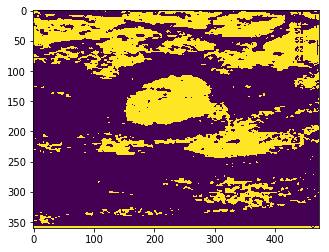

In [18]:
region = get_region(scan_window, start_pt, end_pt)
region_min = absolute_min(region)
region_max = absolute_max(region)

ret, seed_range_thresholded_image = cv2.threshold(scan_window, region_min, region_max, cv2.THRESH_BINARY_INV)
seed_range_thresholded_image = (seed_range_thresholded_image > 0).astype(np.uint8)

plt.imshow(seed_range_thresholded_image)

/Users/Matthew/miniconda3/envs/research/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


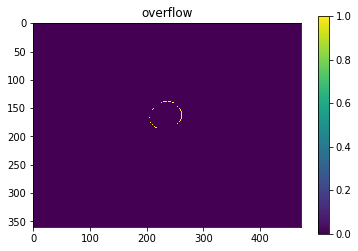

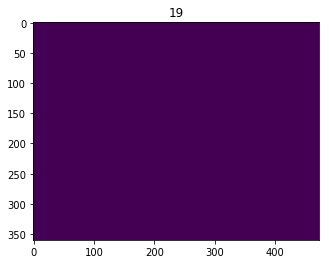

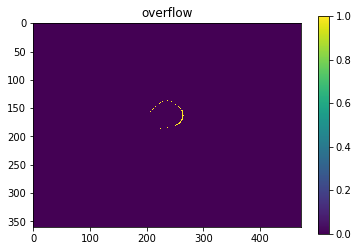

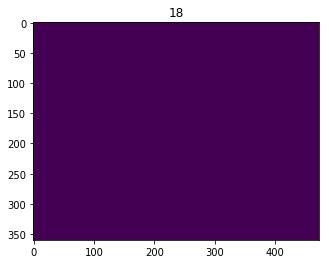

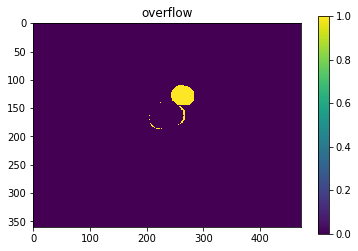

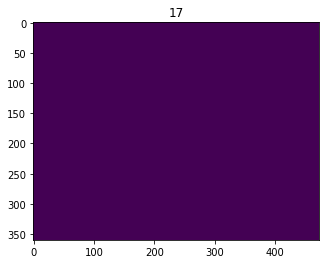

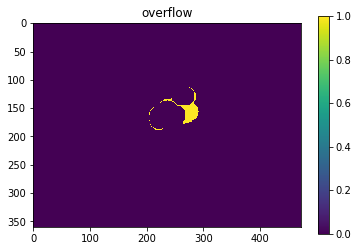

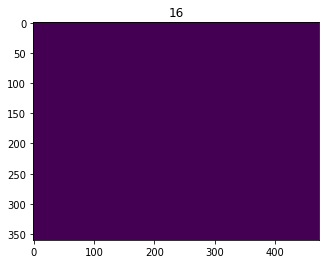

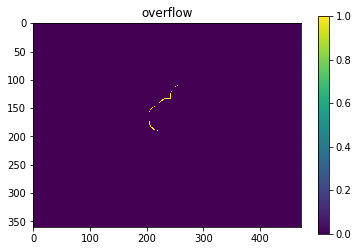

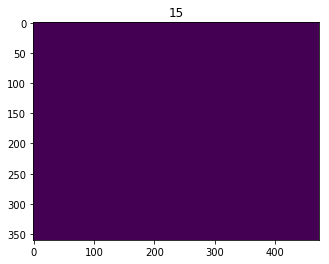

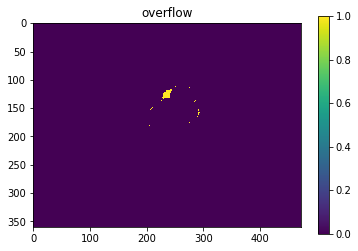

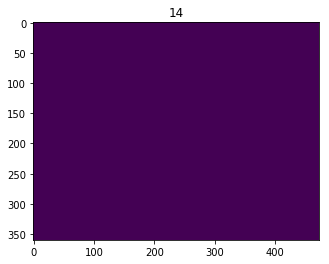

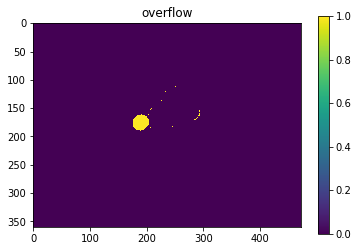

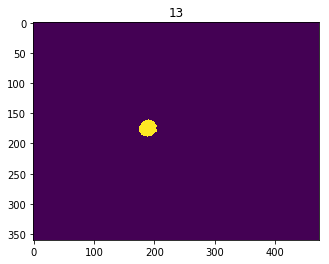

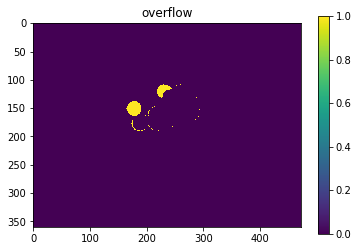

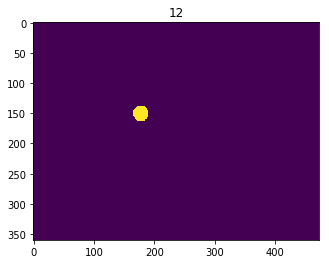

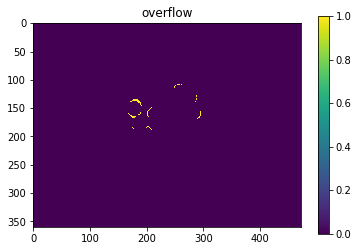

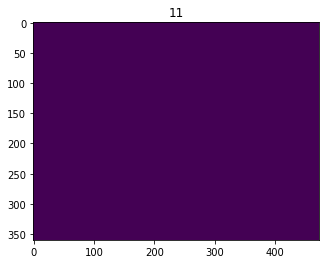

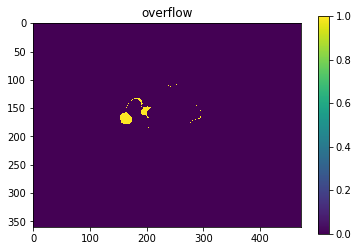

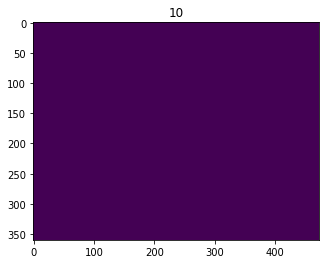

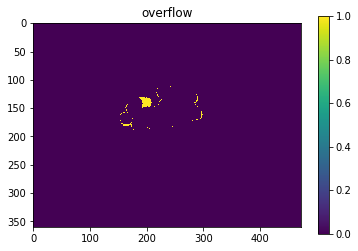

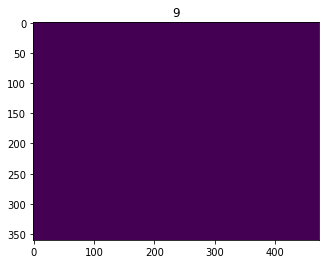

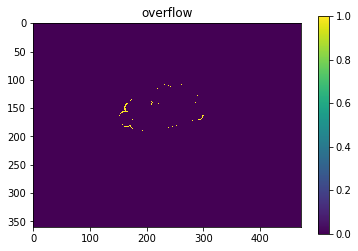

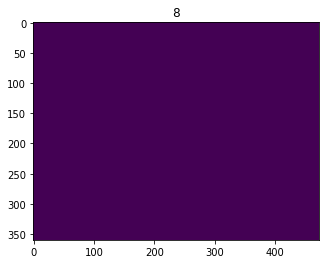

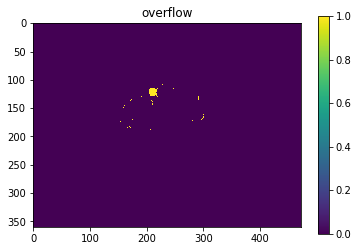

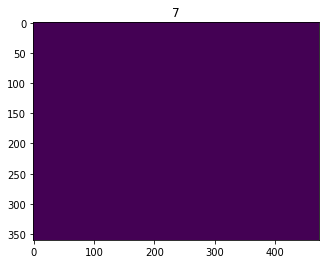

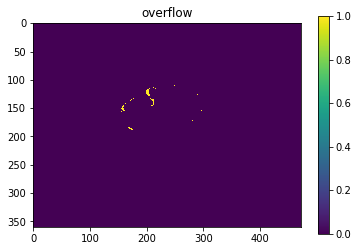

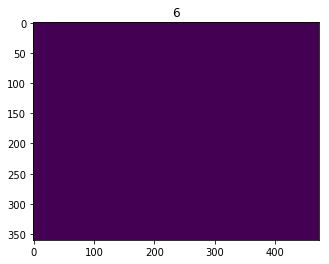

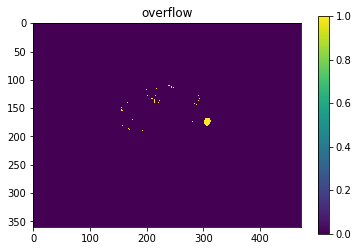

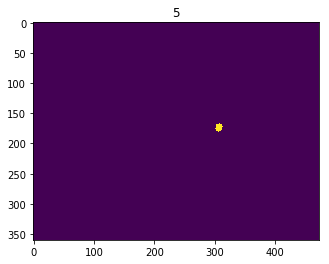

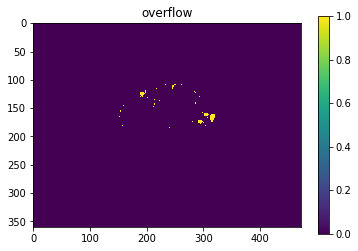

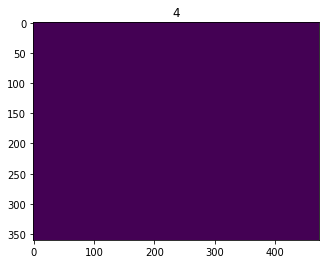

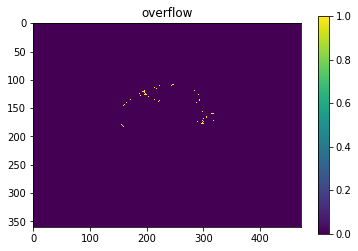

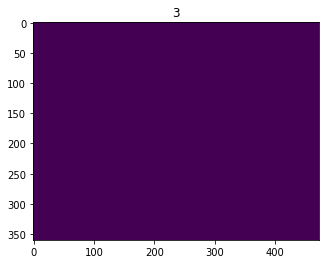

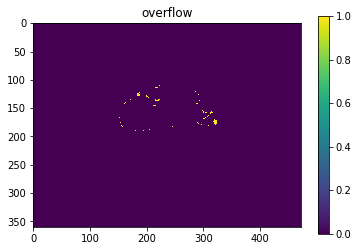

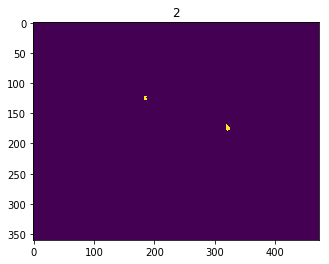

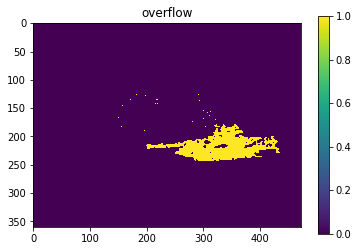

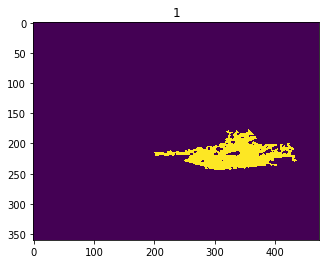

In [47]:
previous_grown = None
composite_leak = np.zeros(seed_region_mask.shape)

for radius in range(MAX_RADIUS, MIN_RADIUS-1, -1):

    radius_grown = iterate_until_stop_growing_exponential_backoff(
        np.copy(seed_region_mask),
        grow_region,
        seed_range_thresholded_image,
        disk_kernel(radius),
        iters_per_round = 3)

    if previous_grown is None:
        previous_grown = np.copy(radius_grown)
        
    else:
#         plt.title("Grown region")
#         ax[0].imshow(radius_grown)
        
    # UINT8 SUBTRACTION IS CAUSING OVERFLOW
        overflow = as_binary_mask(radius_grown - previous_grown)
        
        plt.figure()
        plt.title("overflow")
        plt.imshow(overflow)
        plt.colorbar()
        
        # Prune the overflow to produce leak image
        leak_mask = find_leak_mask_to_kernel_radius(overflow, radius + 1)
        composite_leak += leak_mask
        
        plt.figure()
        plt.imshow(leak_mask)
        plt.title(radius)

#         plt.figure()
#         plt.title("pruned_mask")
#         plt.imshow(pruned_mask)
#         plt.colorbar()
        
#         plt.title("composite")
#         ax[3].imshow(radius_grown + pruned_mask)
        
        previous_grown = radius_grown

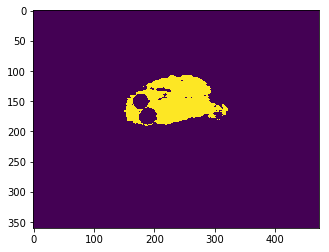

In [43]:
plt.imshow(radius_grown - as_binary_mask(composite_leak))